# Project 3

## Task 3

This task is to explore transfer learning by following the [official pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

As with the previous tutorial, I did a lot of copy and pasting so I will give explanations for the functions as I go along to show that I actually understand what is happening.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, models
from torchvision.utils import make_grid
from pathlib import Path

from task2_functions import test
from task3_functions import (data_transforms, view_grid, train_model,
                             visualize_model, explore_wrong_5x5_rgb)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


This next block creates Dataloaders and records some metadata about the data (size and class names). The Dataloaders are applying transforms to the input dataset ('hymenoptera'). Both the 'train' and 'val' transforms are doing some normalization, but the 'train' transform is also taking a random, resized crops of each input image and randomly flipping images (data augmentation).

In [2]:
data_dir = Path('data/hymenoptera')
image_datasets = {x: datasets.ImageFolder(data_dir / x,
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: data\hymenoptera\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: data\hymenoptera\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


In the next block, I am grabbing a single batch of data from the 'train' Dataloader and using a function I am calling `view_grid` along with the pytorch function `make_grid` to look at the data and some class labels. `view_grid` code is copied from the tutorial, but I changed the name of the function (originally `imshow`) to not be confused with `plt.imshow`.

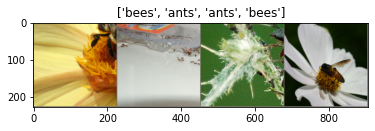

In [3]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)

view_grid(out, title=[class_names[x] for x in classes])

This next bit starts to show how the transfer learning is taking place. First, I am loading a pretrained ResNet and taking a peek at `fc`, which is the final fully connected layer:

In [4]:
model_ft = models.resnet18(pretrained=True)
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

This fully connected layer takes 512 features in and outputs 1000 features. We only need two features to account for ants and bees, so we make a new `fc`:

In [5]:
model_ft.fc = nn.Linear(512, 2)
model_ft = model_ft.to(device)

### Finetuning approach

I am again using cross entropy for the loss function and stochastic gradient descent for optimization. Except this time I will also use a scheduler to adjust the learning rate as training progresses:

In [6]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

The training function is largely copied from the tutorial. It differs from the training function from the FashionMNIST tutorial in several respects. First, it is combining training and testing phases for each epoch in one function, and it has a parameter for specifying the number of epochs. This is convenient. It also is using a scheduler to adjust the learning rate. Interestingly, it is also freezing a copy of the running best model weights as training progresses. This would be helpful if model performance starts to degrade as training progresses (e.g., from overtraining).

For this run, I are training the entire ResNet, but starting from pretrainied weights for all but the fully connected layer ("finetuning"). This runs pretty quickly for me, since I am using a powerful GPU. This is doing the task somewhat backward from the assignment, but I thought finetuning was conceptually straightforward, and fast enough, so I went with that first.

In [7]:
model_ft = train_model(device, dataloaders, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5718 Acc: 0.7008
val Loss: 0.2676 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4964 Acc: 0.7787
val Loss: 0.3376 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5883 Acc: 0.7951
val Loss: 0.3946 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.7862 Acc: 0.7295
val Loss: 0.8114 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.5330 Acc: 0.8074
val Loss: 0.3848 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.5466 Acc: 0.8197
val Loss: 0.3512 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5260 Acc: 0.7869
val Loss: 0.2274 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2584 Acc: 0.8811
val Loss: 0.2372 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2988 Acc: 0.8811
val Loss: 0.2490 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3694 Acc: 0.8443
val Loss: 0.2421 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3159 Acc: 0.8525
val Loss: 0.2563 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2803 Acc: 0.8852
val Loss: 0.2458 Acc: 0.9346

Ep

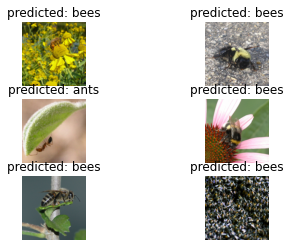

In [8]:
visualize_model(device, dataloaders, class_names, model_ft)

In [9]:
torch.save(model_ft, 'models/tfrln')

My best model gave me ~95% accuracy on the test data:

In [10]:
model_best = torch.load('models/tfrln_best')
test(device, dataloaders['val'], model_best, criterion)

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.207482 



I modified my function to explore wrong guesses from Task 2 to handle the normalized RGB data the dataloaders used here. Also, since I don't necessarily have enough wrongs answers to make a 5x5 grid due to many fewer data examples than in Task 2, I added a parameter to select from wrong answers with replacement.

Interestingly it looks like a lot of the wrong answers probably have to do with environmental context - we're seeing bees on the ground being called ants, and ants on plants being called bees.

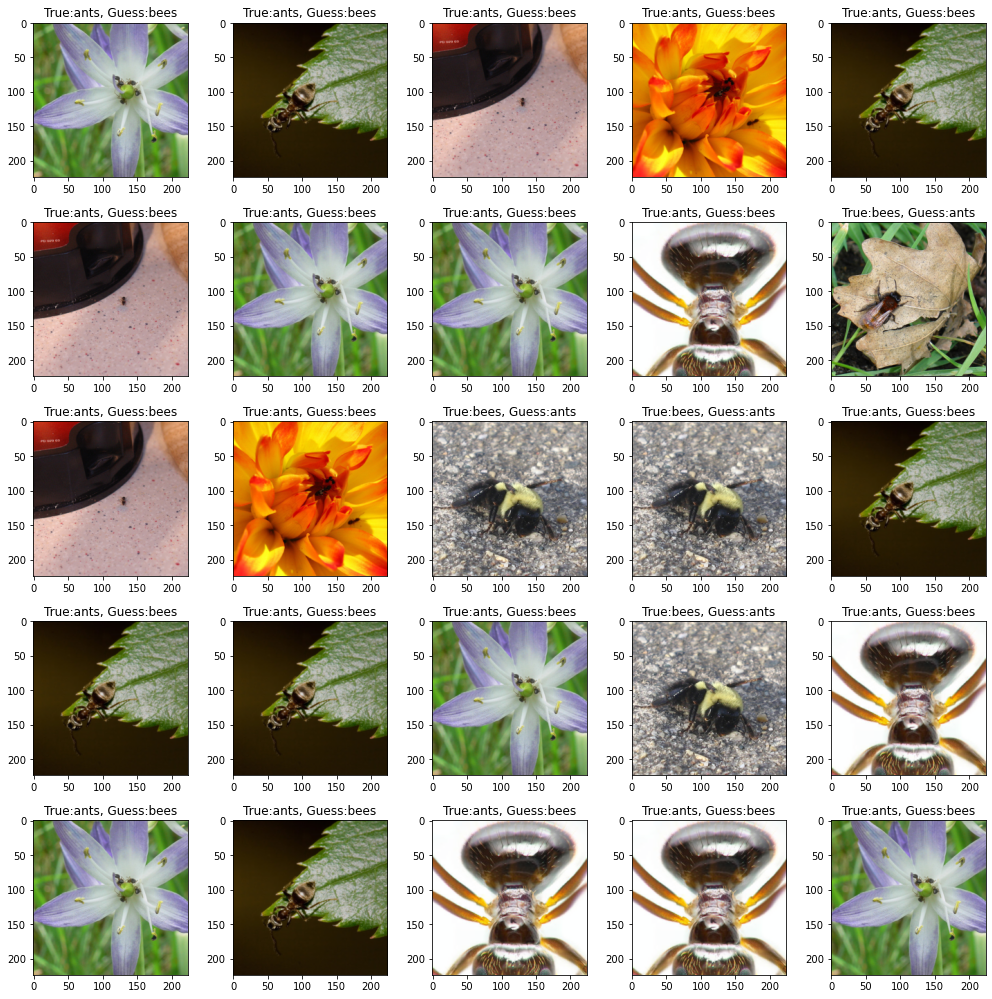

In [11]:
explore_wrong_5x5_rgb(dataloaders['val'], model_best, device, class_labels=class_names, seed=12345, replace=True)

### Feature Extraction approach

Finally, I tried just using the network as a feature extracter and only trained the final fully connected layer instead of training the entire thing:

In [12]:
model_transfer = models.resnet18(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 2)  # requires_grad=T is default
model_transfer = model_transfer.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(),  # only train fc
                               lr=0.001,
                               momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=7, gamma=0.1)

In [13]:
model_transfer = train_model(device, dataloaders, dataset_sizes, model_transfer, criterion, optimizer_transfer,
                             exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5789 Acc: 0.7008
val Loss: 0.3712 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.4717 Acc: 0.7828
val Loss: 0.2244 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4161 Acc: 0.8156
val Loss: 0.2180 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5611 Acc: 0.7459
val Loss: 0.2235 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3609 Acc: 0.8443
val Loss: 0.1741 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3450 Acc: 0.8525
val Loss: 0.5491 Acc: 0.7974

Epoch 6/24
----------
train Loss: 0.5070 Acc: 0.7910
val Loss: 0.2297 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3510 Acc: 0.8320
val Loss: 0.1559 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3051 Acc: 0.8852
val Loss: 0.1765 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3614 Acc: 0.8320
val Loss: 0.1609 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3149 Acc: 0.8566
val Loss: 0.1674 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3894 Acc: 0.8525
val Loss: 0.1853 Acc: 0.9346

Ep

The feature extractor approach trained in half the time and performed comparably to the finetuning approach!

## Appendix

### task3_functions.py

```python
import copy
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from numpy.random import default_rng

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# convenience functions
def view_grid(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        

def train_model(device, dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(device, dataloaders, class_names, model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                view_grid(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def explore_wrong_5x5_rgb(dataloader, model, device, class_labels=None, seed=None, replace=False):

    model.eval()
    rng = default_rng(seed)
    all_wrong = torch.empty(0, dtype=torch.int64, device=device)
    preds = torch.empty(0, dtype=torch.int64, device=device)
    gtruths = torch.empty(0, dtype=torch.int64, device=device)
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X).argmax(1)
        wrong = pred != y
        wrong_ixs = torch.argwhere(wrong).flatten()
        for ix in wrong_ixs:
            all_wrong = torch.cat((all_wrong, X[ix, ...][None, ...]))
            preds = torch.cat((preds, torch.tensor([pred[ix]]).to(device)))
            gtruths = torch.cat((gtruths, torch.tensor([y[ix]]).to(device)))

    example_ixs = rng.choice(range(len(gtruths)), 25, replace=replace)

    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    fig.tight_layout()
    for i, ix in enumerate(example_ixs):
        X = all_wrong[ix]
        y = gtruths[ix]
        y_guess = preds[ix]
        if class_labels:
            true = class_labels[y]
            guess = class_labels[y_guess]
        else:
            true = str(int(y))
            guess = str(int(y_guess))
        ax = axes.flatten()[i]
        ax.set_title(f'True:{true}, Guess:{guess}')
        im = X.squeeze().cpu().numpy()
        im = np.moveaxis(im, 0, -1)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        im = np.clip(im, 0, 1)
        ax.imshow(im)
    model.train()
```